# PROGETTO DI INTRODUZIONE ALL'INTELLIGENZA ARTIFICIALE A.A 2023-2024:

## ABSTRACT
Questo studio si propone di replicare l'ambiente e gli agenti descritti nel paper ["Addiction beyond pharmacological effects: The role of environment complexity and bounded rationality"](https://www.sciencedirect.com/science/article/abs/pii/S0893608019301285) al fine di validare e comprendere più approfonditamente i risultati ottenuti nell'ambito del Reinforcement Learning. Il paper presenta un ambiente di simulazione e una serie di agenti intelligenti che operano all'interno di esso. L'obiettivo principale della nostra ricerca è quello di ricostruire fedelmente l'ambiente di simulazione e implementare gli agenti descritti utilizzando una libreria standard di Reinforcement Learning, come OpenAI Gym. 
Attraverso la ricreazione di questo ambiente e l'implementazione degli agenti, intendiamo esplorare le dinamiche sottostanti del problema descritto, testare le strategie di apprendimento automatico proposte e confrontare i risultati con quelli riportati nel paper originale. La nostra riproduzione dell'ambiente e degli agenti fornirà una base solida per ulteriori ricerche nel campo dell'apprendimento automatico e dell'intelligenza artificiale, consentendo una migliore comprensione e validazione dei risultati riportati nel paper.

## MEMBRI DEL GRUPPO
Il progetto è stato svolto da: 
- Alessandro Verdi 886134
- Gabriele Maggi 886197

# IMPLEMENTAZIONE

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional


## DEFINIZIONE AMBIENTE
**Descrizione dell'Ambiente Gym:**

L'ambiente è stato implementato utilizzando la libreria Python Gym e simula un processo di transizione tra stale, con particolare enfasi sullo sviluppo dell'addizione. Gli stati sono definiti come segue:

- **Stato 1:** Healthy
- **Stati 2-n** aleutri
- **Stati 8-22:** Addicted

**Azioni:**

Sono disponibili nove azioni distinte:

- **as2-as7:** Per spostarsi rispettivamente negli stati 2-7.
- **ag:** Per spostarsi nello stato Healthy.
- **aw e ad:** Per avanzare nell'addizione.

**Ricompense:**

Le ricompense sono definite come segue:

- **+1:** Una volta che l'agente entra nello stato Healthy.
- * +10:** Una volta che l'agente entra negli stati Addicted.
- **-4:** Per uscire dagli stati Addicted.
- **-1 e -2:** Per muoversi tra gli stati Addicted.

Questo ambiente offre un quadro per l'esplorazione dei processi di sviluppo dell'addizione e delle strategie per mantenere o recuperare uno stato di salute mentale. 

## IMPLEMENTAZIONE AMBIENTE

In [10]:
class AddictiveEnv(gym.Env):
    def __init__(self):
        # PARAMS
        self.NT = 23  # Numero di stati + 1 
        self.NA = 9   # Numero of actions
        self.S0 = 4   # Starting state
        self.RP = -4  # Punishment end of Addictive Area
        self.RC = -1.2  # Punishment in Addictive Area
        self.RDD = 10  # Reward at entering Addictive reward state
        self.RG = 1    # Reward 
        self.DINIT = 50  # Duration safe phase
        self.DDRUG = 1000

        self.pmm = 0.6
        self.pm = 0.9
        ## ACTIONS
        #as2-7 -> 0-5
        self.AG = 6
        self.AW = 7
        self.AD = 8

        truncated = False
        
        self.AR = ["as2", "as3", "as4", "as5", "as6", "as7", "aG", "aW", "aD",]
        # ag -> 6
        # aw -> 7
        # ad -> 8
        # Observation space (20 stati 1 healty, 2-7 neutral 8-22 dipendenza)
        self.observation_space = spaces.Discrete(self.NT) # non uso stato 0 
        # Actions spaces (9 azioni -> as 2-7, ag, aw, ad)
        self.action_space = spaces.Discrete(self.NA) 
        # stato iniziale: 4        
        self.state = self.S0
        # env_phase: 0-50 safe -> addictive deactivated
        # env_phase: 50-2000 safe -> addictive activated
        self.env_phase = 0 
           

    def _get_obs(self):
        return self.state

    
    def step(self, action):
        
        info = {}
        # safe phase
        if (self.env_phase < self.DINIT):
            # muovo 2-7 p=1 su adiacenti e p << 1 su lontani
                              
            if (action == 6 and self.state == 2):
                info = "sf mi muovo da " + str(self.state) + " a healty" + " action: " + self.AR[action] + " 3"
                self.state = 1
                reward = 0
                
            elif (action == 6 and self.state == 1):
                self.state = self.S0
                info = "sf mi muovo da " + "healty" + " a " + str(self.S0) + " action: " + self.AR[action] + " 4"
                reward = self.RG
                
            elif (action < 6 and self.state != 1): # movimenti tra stati neutrali 2-7
                
                if (self.state - 1 <= action + 2 <= self.state + 1):
                    info = "sf mi muovo da " + str(self.state) + " a " + str(action + 2) + " action: " + self.AR[action] + " 1"
                    self.state = action + 2
                    reward = 0
                    
                else:
                    s = str(self.state)
                    sampleList = [self.state, action + 2] # con probabilità p << 1 il salto di stato, se no rimango dove sono 
                    self.state = choice(sampleList, 1, p = [(1-self.pmm), self.pmm])[0]
                    info = "sf mi muovo da " + s + " a " + str(self.state)+ " action: " + self.AR[action] + " 2"
                    reward = 0
            
            else:
                self.state = self.state
                info = "sf non mi muovo da " + str(self.state) + " 5"
                reward = 0
        # rest of the phases
        else:
            if (self.state < 8):
                if (action < 6 and self.state != 1):
                     if (self.state - 1 <= action + 2 <= self.state + 1):
                        info = "mi muovo da " + str(self.state) + " a " + str(action + 2)+ " action: " + self.AR[action] + " 6"
                        self.state = action + 2
                        reward = 0
                         
                     else:
                        s = str(self.state)
                        sampleList = [self.state, action + 2] # con probabilità p << 1 il salto di stato, se no rimango dove sono 
                        self.state = choice(sampleList, 1, p = [(1-self.pmm), self.pmm])[0]
                        info = "mi muovo da " + s + " a " + str(self.state)+ " action: " + self.AR[action] + " 7"
                        reward = 0
                         
                elif (action == 6 and self.state == 2):
                    info = "mi muovo da " + str(self.state) + " a healty" + " action: " + self.AR[action] + " 8"
                    self.state = 1
                    reward = 0
                    
                elif (action == 6 and self.state == 1): # stato sano
                    info = "mi muovo da " + "healty" + " a " + str(self.S0) + " action: " + self.AR[action] + " 9"
                    self.state = self.S0
                    reward = self.RG
                    
                elif (action == self.AD and self.state == 7): # stato dipendenza
                    self.state = 8
                    info = "addicted"+ " action: " + self.AR[action] + " 10"
                    reward = self.RDD
                    
                else:
                    self.state = self.state
                    info = "non mi muovo da " + str(self.state) + " 11"
                    reward = 0
                    
            elif (self.state >= 8 and self.state <= 22): # stati di after effects
                if (self.state == 20 and (action == self.AW or action == self.AD)):
                    s = str(self.state)
                    sampleList = [self.state, self.S0] # con probabilità p << 1 il salto di stato, se no rimango dove sono 
                    self.state = choice(sampleList, 1, p = [(1-self.pmm), self.pmm])[0]
                    info = "mi muovo da " + s + " a " + str(self.state) + " action: " + self.AR[action] + " 12"
                    reward = self.RP
                    
                elif (self.state == 15 and action == self.AW):
                    s = str(self.state)
                    sampleList = [self.state, self.S0] # con probabilità p < 1 il salto di stato, se no rimango dove sono 
                    self.state = choice(sampleList, 1, p = [(1-self.pm), self.pm])[0]
                    info = "mi muovo da " + s + " a " + str(self.state) + " action: " + self.AR[action] + " 13"
                    reward = self.RP
                    
                elif (action == self.AW or action == self.AD):
                    if (self.state != 8 and self.state != 22):
                        s = str(self.state)
                        sampleList = [self.state, self.state - 1, self.state + 1] # con probabilità p < 1 il salto di stato, se no rimango dove sono 
                        self.state = choice(sampleList, 1, p = [(1 - (self.pm)), self.pm/2, self.pm/2])[0]
                        info = "mi muovo da " + s + " a " + str(self.state) + " action: " + self.AR[action] + " 14"
                        reward = self.RC
                    elif (self.state == 8):
                        s = str(self.state)
                        sampleList = [self.state, self.NT - 1, self.state + 1] # con probabilità p < 1 il salto di stato, se no rimango dove sono 
                        self.state = choice(sampleList, 1, p = [(1 - (self.pm)), self.pm/2, self.pm/2])[0]
                        info = "mi muovo da " + s + " a " + str(self.state) + " action: " + self.AR[action] + " 15"
                        reward = self.RC
                    elif (self.state == 22):
                        s = str(self.state)
                        sampleList = [self.state, self.state - 1, 8] # con probabilità p < 1 il salto di stato, se no rimango dove sono 
                        self.state = choice(sampleList, 1, p = [(1 - (self.pm)), self.pm/2, self.pm/2])[0]
                        info = "mi muovo da " + s + " a " + str(self.state) + " action: " + self.AR[action] + " 16"
                        reward = self.RC
                else:
                    info = "non mi muovo da " + str(self.state) + " 17"
                    reward = -1.2
                

        # check if done
        if (self.env_phase == self.DDRUG + self.DINIT):
            done = True
        else:
            done = False
            self.env_phase += 1  
        
        return self._get_obs(), reward, terminated, False, info

    def render(self):
        pass
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        
        self.state = self.S0
        self.env_phase = 0 
        
        return self._get_obs(), {}
        
    def close(self):
        pass 
        


In [11]:

env = gymnasium.make('AddictiveEnv')





ValueError: Empty module name

## IMPLEMENTAZIONE AGENTE MF
L'agente MF basato su Q-Learning è progettato per apprendere una politica ottimale di azioni in un ambiente senza avere conoscenza diretta del modello di transizione di stato o delle ricompense. In questo contesto, utilizza una funzione Q, chiamata anche "funzione valore d'azione", per valutare la bontà di ciascuna azione in uno stato specifico.

In [450]:
class QLearningAgent:
    def __init__(self, learning_rate: float,  initial_epsilon: float,   epsilon_decay: float,  final_epsilon: float,   discount_factor: float = 0.95):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return self.env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_table[state]) # Exploit learned values
    
    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state, action] 
        next_max = np.max(self.q_table[next_state, :])
        self.q_table[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## ANALISI DEI RISULTATI AGENTE MF

In [451]:
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = QLearningAgent(
    learning_rate=0.9,
    initial_epsilon=0.9,
    epsilon_decay=epsilon_decay,
    final_epsilon=0.1,
)

In [452]:
env = CustomEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|                                                                                                                                                                                                                                                                                            | 0/100000 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable int object

## IMPLEMENTAZIONE AGENTE MB

In [400]:
class ModelBasedAgent:
    def __init__(self, env, alpha=0.6, gamma=0.6, epsilon=0.1):
        self.env = env

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])
        self.transition_model = {}  # Struttura dati contenente T e R insieme
        self.initialize_transition_model()
        self.test_rewards = []
        self.addiction_states = []
        
    def initialize_transition_model(self):
        for state in range(1, self.env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(self.env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(self.env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
                    
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        
    
    def calculate_transition_probabilities(self):
        for state in range(1, self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
                    #if  self.transition_model[state][action][next_state]['probability'] != 0:
                    #    print(f"{state} {action} {next_state} { self.transition_model[state][action][next_state]['probability']}")


    
    def value_iteration(self, iter=100):
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, self.env.observation_space.n):
                for action in range(0, self.env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.gamma * np.max(self.q_table[next_state]))
                    self.q_table[state][action] = t
                     
                Vs = abs(self.q_table[state][action] - np.max(self.q_table[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0:
                break
        print("Value iter finished")
        #print(self.q_table[7])
        


        
    
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return self.env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_table[state]) # Exploit learned values
            
    
    def explore(self, n_epochs = 100):
        eps = self.epsilon # mi salvo epsilon per fare solo passi a caso
        self.epsilon = 1 
        for i in range(1, n_epochs + 1):
            state = self.env.reset()
            done = False   
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_transition_model(state, action, next_state, reward)
                state = next_state
            if i % 100 == 0:
                print(f"Episode: {i}")
        self.calculate_transition_probabilities()  # Calculate transition probabilities after training
        print(f"Training finished.")
        self.epsilon = eps
    
    def test(self, n_episodes=100):
        self.epsilon = 0
        for _ in range(n_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            addiction = 0
        
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                total_reward += reward
                
                if state == 8:
                    addiction += 1
            self.test_rewards.append(total_reward)
            self.addiction_states.append(addiction)

    def plot_results(self):
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.test_rewards)
        plt.title('Test Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
      
        plt.subplot(1, 2, 2)
        plt.plot(self.addiction_states)
        plt.title('Addiction Rewards (testing)')
        plt.xlabel('Episode')
        plt.ylabel('Total addicted')
        
        plt.tight_layout()
        plt.show()

## ANALISI DEI RISULTATI AGENTE MB

In [401]:
 agent = ModelBasedAgent(env)
 agent.explore(1000)
 agent.value_iteration()


Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Training finished.
Value iter finished


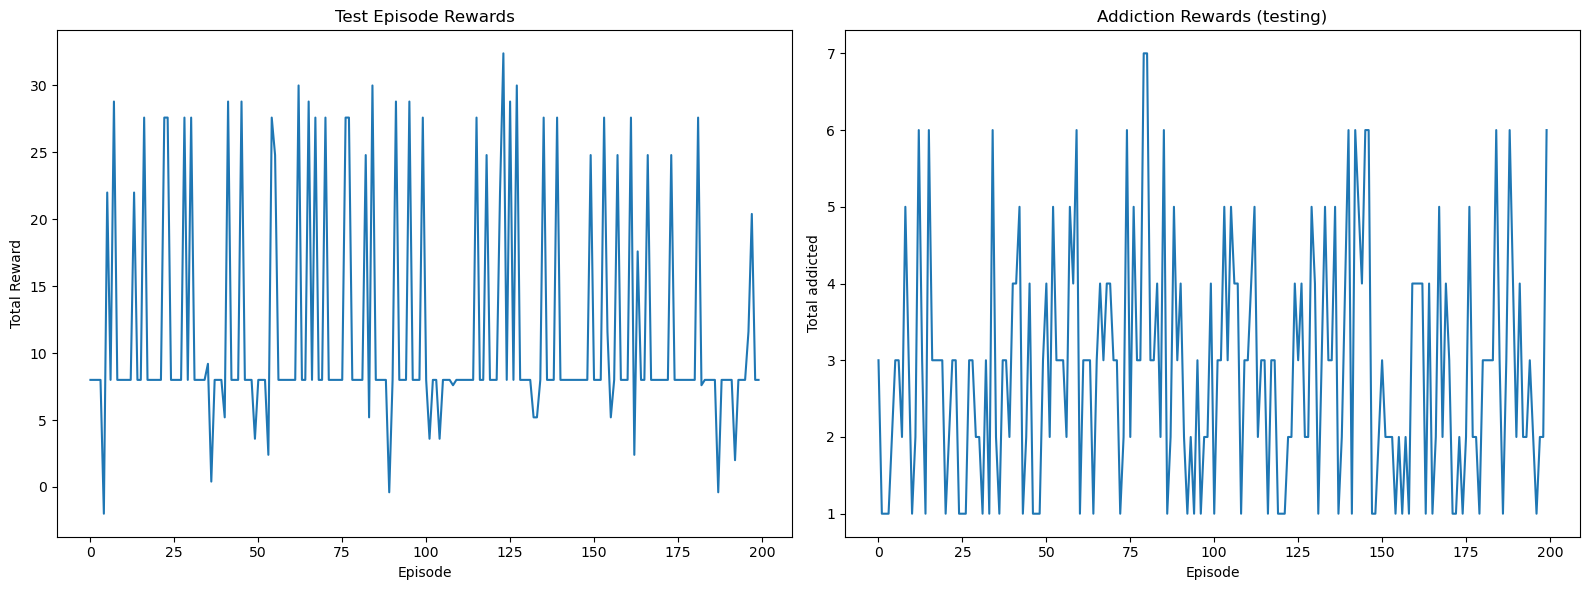

In [404]:
 agent.test(100) 
 agent.plot_results()